In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from scipy import signal
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.stats.outliers_influence import OLSInfluence

from statsmodels.tsa.stattools import acf, pacf

In [2]:
train_data = pd.read_csv("../data/power-laws-detecting-anomalies-in-usage-training-data.csv", sep=";")
building = pd.read_csv("../data/power-laws-detecting-anomalies-in-usage-metadata.csv", sep=";")
weather = pd.read_csv("../data/power-laws-detecting-anomalies-in-usage-weather.csv", sep=";")
holidays = pd.read_csv("../data/power-laws-detecting-anomalies-in-usage-holidays.csv", sep=";")

"""
print(train_data.columns)
print(building.columns)
print(weather.columns)
print(holidays.columns)
"""

In [3]:
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'])
train_data.sort_values(by="Timestamp", ascending=True, inplace=True)

weather["Timestamp"] = pd.to_datetime(weather["Timestamp"])
weather.sort_values(by="Timestamp", ascending=True, inplace=True)

In [4]:
# Confirms that all meter_ids are unique in building data
print(building["meter_id"].nunique() == building[~building["meter_id"].isna()].shape[0])

final_building = building[building["site_id"].str.startswith("234")]

# Extracting the unique meter_ids and filtering train_data with those
train = train_data[train_data["meter_id"].isin(final_building["meter_id"].unique())]
train

True


,meter_id,Timestamp,Values
3104961,930,2013-11-03 05:30:00+05:30,0.0
2373655,234_203,2013-11-03 05:30:00+05:30,NaN
1022147,938,2013-11-03 05:30:00+05:30,NaN
958523,935,2013-11-03 05:30:00+05:30,0.0
557934,935,2013-11-03 06:00:00+05:30,0.0
...,...,...,...
1835488,925,2018-01-08 05:00:00+05:30,0.0
2418097,887,2018-01-08 05:00:00+05:30,0.0
1670601,935,2018-01-08 05:00:00+05:30,0.0
3464057,896,2018-01-08 05:00:00+05:30,1969.0


In [5]:
holidays["site_id"].unique()  # No holiday data

array(['038', '334_61'], dtype=object)

### Merging meter_description and activity 

In [6]:
train_final = train.merge(final_building[["meter_id", "meter_description", "activity"]], how="left", on="meter_id")
# train_final

### Extracting data for meter 869

In [7]:
train_final["meter_id"].value_counts()

234_203    73200
878        73152
884        73152
872        73152
887        73152
890        73152
881        73152
938        73104
930        73056
935        73056
928        73008
911        73008
920        73008
902        73008
869        71904
925        36432
875        35856
896        35760
Name: meter_id, dtype: int64

In [8]:
# Number of missing values
np.sum(train_final[train_final["meter_id"] == "869"]["Values"].isna())

18

In [9]:
train_869 = train_final[train_final["meter_id"] == "869"]
# train_869

In [10]:
# Aggregating on a daily basis
train_daily = train_869.groupby(train_869["Timestamp"].dt.date).agg({'Values': 'mean'})
train_daily.reset_index(inplace=True)

In [11]:
# Filtering data for 2016
train_daily["Timestamp"] = pd.to_datetime(train_daily["Timestamp"])
train_2016 = train_daily[train_daily["Timestamp"].dt.year == 2016]

In [12]:
train_2016.shape

(366, 2)

### Plotting the time series

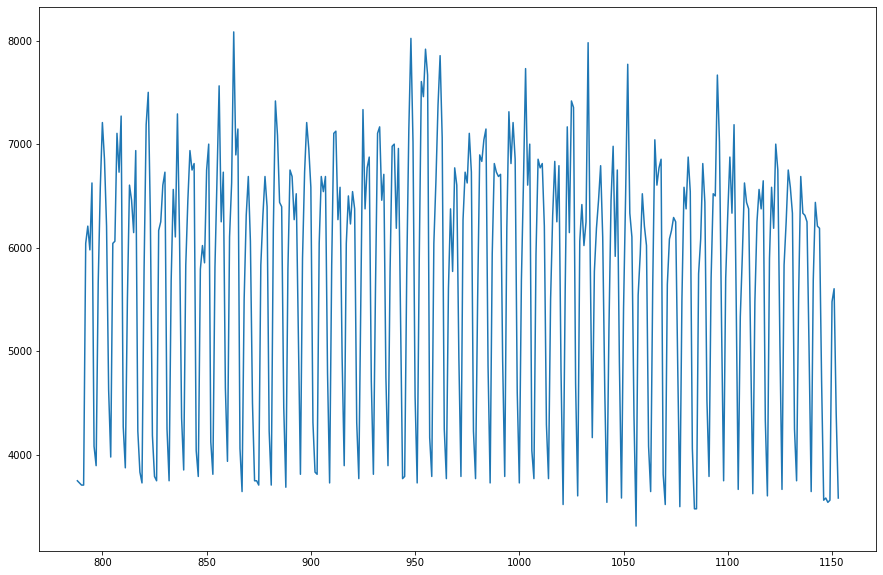

In [13]:
plt.figure(figsize=(15,10))
plt.plot(train_2016.loc[:,'Values'])
plt.show()

### Seasonality

In [14]:
freq, amp = signal.periodogram(x=train_2016["Values"] - train_2016["Values"].mean(), detrend='constant')

In [15]:
freq_max = freq[amp.argmax()]
seasonality = 1 / freq_max
seasonality

7.038461538461539

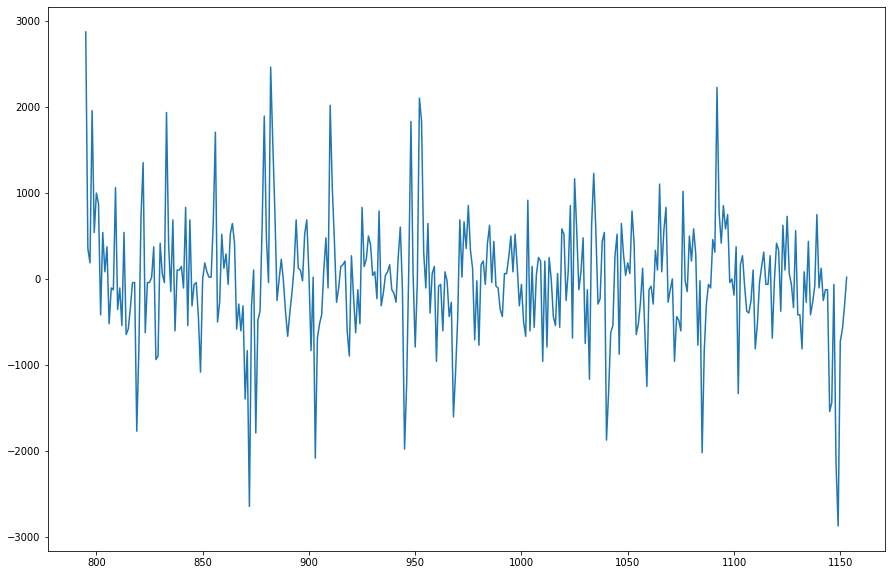

In [16]:
# Taking seasonality as 7 and calculating the seasonal difference
seasonal_difference_7 = train_2016["Values"] - train_2016["Values"].shift(7)
plt.figure(figsize=(15,10))
plt.plot(seasonal_difference_7)
plt.show()

### ACF of original TS

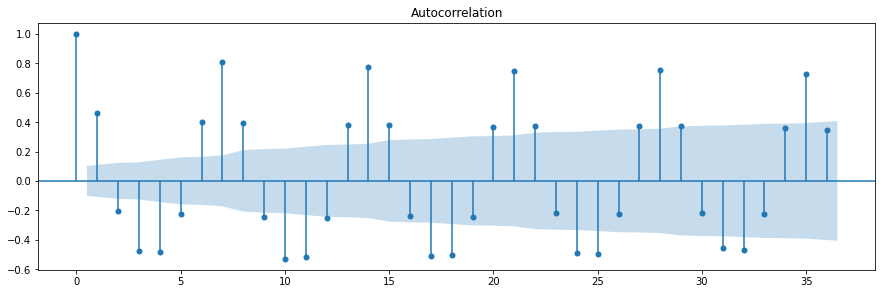

In [17]:
figure = plt.figure(figsize=(15,10))
axis1 = figure.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_2016["Values"], lags=36, ax=axis1)

### PACF of original TS

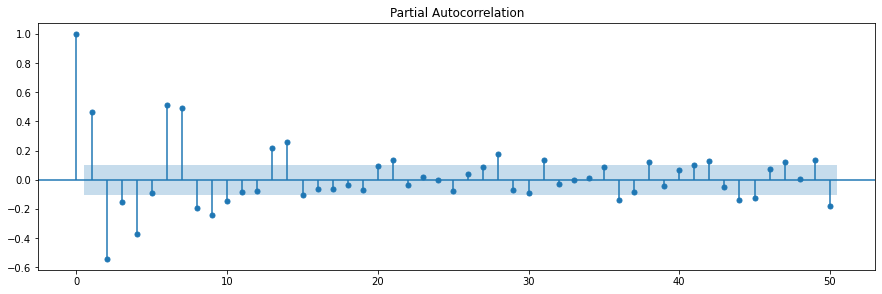

In [18]:
figure = plt.figure(figsize=(15,10))
axis2 = figure.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_2016["Values"], lags=50, ax=axis2)

### ACF of differenced TS

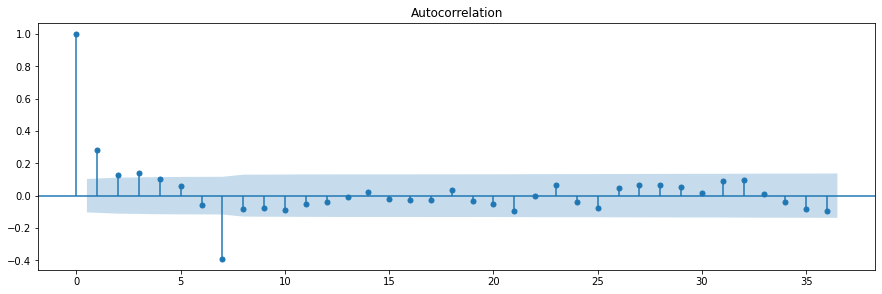

In [19]:
figure = plt.figure(figsize=(15,10))
axis3 = figure.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(seasonal_difference_7.dropna(), lags=36, ax=axis3)

### PACF of differenced TS

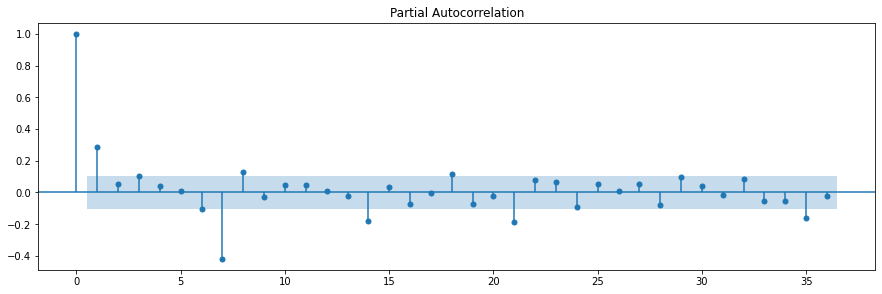

In [20]:
figure = plt.figure(figsize=(15,10))
axis4 = figure.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(seasonal_difference_7.dropna(), lags=36, ax=axis4)

### ACF and PACF values

In [21]:
acf_values = acf(seasonal_difference_7.dropna(), alpha=0.05, nlags=36)
pacf_values = pacf(seasonal_difference_7.dropna(), alpha=0.05, nlags=36)

/home/aumaron/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


#### Subtracting the respective ACF/ PACF values from their confidence intervals gives the intervals centred around 0

In [22]:
acf_conf_int = acf_values[1] - acf_values[0][:, None]
pacf_conf_int = pacf_values[1] - pacf_values[0][:, None]
#print(acf_conf_int)
#print(pacf_conf_int)

### Model training

In [23]:
# Jan to Oct data will be used for training
train_forecast = train_2016[train_2016["Timestamp"].dt.month <= 10]
train_forecast.reset_index(inplace=True, drop=True)
# train_forecast

In [24]:
# Series to be used in training 
series = np.array(train_forecast["Values"])

In [25]:
# Defined the time series split criteria
tscv = TimeSeriesSplit(n_splits=4, test_size=7)

### Model 1:  001 0117

In [26]:
model_one_pred_mean = []
model_one_actual = []
model_one_conf_interval = []
for train_index, test_index in tscv.split(series):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = series[train_index], series[test_index]
    _model_one = ARIMA(endog=X_train, order=(0, 0, 1), seasonal_order=(0,1,1,7)).fit()
    predict = _model_one.get_forecast(steps=7)
    model_one_pred_mean.extend(list(predict.predicted_mean))
    model_one_actual.extend(X_test)
    model_one_conf_interval.extend(list(predict.conf_int(alpha=0.05)))

#     print("Actual: ", series[test_index])
#     print("Predict: ", list(predict.predicted_mean))
frame1 = pd.DataFrame({"Dates": train_forecast[train_forecast.index > train_forecast.index[-1] - 28]["Timestamp"].values,
                      "Actual": model_one_actual,
                      "Forecast": model_one_pred_mean, 
                      "lower_limit": [interval[0] for interval in model_one_conf_interval],
                      "upper_limit": [interval[1] for interval in model_one_conf_interval],
                       "Difference": [np.abs(a - p) for a, p in zip(model_one_actual, model_one_pred_mean)]})
mse1 = np.sum([(actual-predicted)**2 for actual, predicted in zip(model_one_actual,model_one_pred_mean)]) / len(model_one_actual)
print("MSE for model 1-> ", mse1)
# frame1

MSE for model 1->  278829.57738097146


### Model 2: 100 3107

In [27]:
model_two_pred_mean = []
model_two_actual = []
model_two_conf_interval = []
X_train = None 
X_test = None
for train_index, test_index in tscv.split(series):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = series[train_index], series[test_index]
    _model_two = ARIMA(endog=X_train, order=(1,0,0), seasonal_order=(3,1,0,7)).fit()
    predict_two = _model_two.get_forecast(steps=7)
    model_two_pred_mean.extend(list(predict_two.predicted_mean))
    model_two_actual.extend(X_test)
    model_two_conf_interval.extend(list(predict_two.conf_int(alpha=0.05)))

frame2 = pd.DataFrame({"Dates": train_forecast[train_forecast.index > train_forecast.index[-1] - 28]["Timestamp"].values,
                      "Actual": model_two_actual,
                      "Forecast": model_two_pred_mean, 
                      "lower_limit": [interval[0] for interval in model_two_conf_interval],
                      "upper_limit": [interval[1] for interval in model_two_conf_interval]})
mse2 = np.sum([(actual-predicted)**2 for actual, predicted in zip(model_two_actual,model_two_pred_mean)]) / len(model_two_actual)
print("MSE for Model 2-> ", mse2)
# frame2

MSE for Model 2->  343550.6128045908


### Model 3: 103 3117

In [28]:
model_three_pred_mean = []
model_three_actual = []
model_three_conf_interval = []
X_train = None
X_test = None
for train_index, test_index in tscv.split(series):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = series[train_index], series[test_index]
    _model_three = ARIMA(endog=X_train, order=(1,0,3), seasonal_order=(3,1,1,7)).fit()
    predict_three = _model_three.get_forecast(steps=7)
    model_three_pred_mean.extend(list(predict_three.predicted_mean))
    model_three_actual.extend(X_test)
    model_three_conf_interval.extend(list(predict_three.conf_int(alpha=0.05)))

frame3 = pd.DataFrame({"Dates": train_forecast[train_forecast.index > train_forecast.index[-1] - 28]["Timestamp"].values,
                      "Actual": model_three_actual,
                      "Forecast": model_three_pred_mean, 
                      "lower_limit": [interval[0] for interval in model_three_conf_interval],
                      "upper_limit": [interval[1] for interval in model_three_conf_interval]})
mse3 = np.sum([(actual-predicted)**2 for actual, predicted in zip(model_three_actual,model_three_pred_mean)]) / len(model_three_actual)
print("MSE -> ", mse3)
# frame3

/home/aumaron/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/aumaron/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/aumaron/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aumaron/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/aumaron/.local/lib/python3.8/site-p

MSE ->  324196.43318444956


In [29]:
print(f"MSE for model [0, 0, 1], [0, 1, 1, 7] is {mse1}.")
print(f"MSE for model [1, 0, 0], [3, 1, 0, 7] is {mse2}.")
print(f"MSE for model [1, 0, 3], [3, 1, 1, 7] is {mse3}.")

MSE for model [0, 0, 1], [0, 1, 1, 7] is 278829.57738097146.
MSE for model [1, 0, 0], [3, 1, 0, 7] is 343550.6128045908.
MSE for model [1, 0, 3], [3, 1, 1, 7] is 324196.43318444956.


### Best model: 001 0117

In [30]:
_model = ARIMA(endog=series, order=(0,0,1), seasonal_order=(0,1,1,7)).fit()
# fitted_values = ARIMAResults(model=_model, params=_model.param_terms).fittedvalues()

In [31]:
fitted_values = _model.fittedvalues
resids = series - fitted_values
residual_standard_deviation = np.std(resids)
print(residual_standard_deviation)
# calculated_residual_standard_deviation = np.sqrt(np.sum([(resids[i] - np.mean(resids))**2 for i in range(len(resids))]) / len(resids))
# print(calculated_residual_standard_deviation)

895.551136857473


In [32]:
standardised_residuals = [resids[i]/residual_standard_deviation for i in range(len(resids))]

In [33]:
output_frame = pd.DataFrame({"Dates": train_forecast["Timestamp"].values,
                             "Actual": series,
                             "Forecast": fitted_values, 
                             "residuals": resids, 
                             "standardised_residual": np.abs(standardised_residuals)})
output_frame["is_outlier"] = False
output_frame.loc[output_frame["standardised_residual"] > 2, "is_outlier"] = True


In [34]:
# output_frame

In [35]:
# Outlier indexes. The first 7 indexes not to be considered as outliers
output_frame[output_frame["is_outlier"]].index.tolist()[8:]

[10, 12, 13, 17, 21, 84, 297]

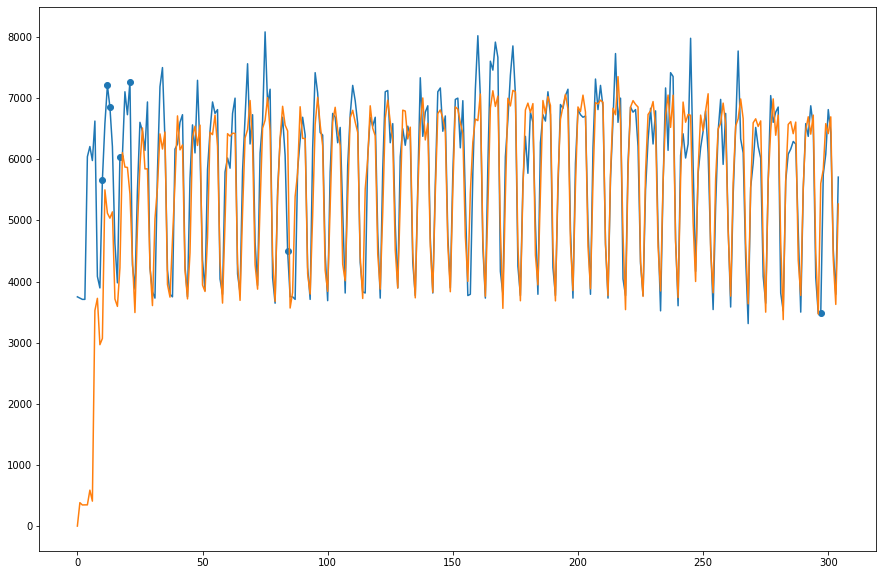

In [36]:
figure1 = plt.figure(figsize=(15,10))
# axis = figure1.add_subplot(212)
markers_on = output_frame[output_frame["is_outlier"]].index.tolist()
plt.plot(series[:310], '-o', markevery=markers_on[8:])
plt.plot(fitted_values[:310])